# Exercise 2: Particle and ParticleSet

The objective of this exercise is to setup a ParticleSet

See documentation: http://oceanparcels.org/gh-pages/html/

First let's create a FieldSet, which defines the Stommel flow.
The Stommel flow is derived from its streamfunction (P) that can be computed analytically.

u =  dP/dy,
v = -dP/dx

In [1]:
from parcels import Field, RectilinearZGrid, FieldSet
import numpy as np
import math

In [2]:
# Some constants
A = 10
eps = 0.05
a = 10000
b = 10000

# Coordinates of the test fieldset (on A-grid)
xdim = 200
ydim = 400
lon = np.linspace(0, a, xdim, dtype=np.float32)
dx = lon[1]-lon[0]
lat = np.linspace(0, b, ydim, dtype=np.float32)
dy = lat[1]-lat[0]
(x, y) = np.meshgrid(lon, lat)

l1 = (-1 + math.sqrt(1 + 4 * math.pi**2 * eps**2)) / (2 * eps)
l2 = (-1 - math.sqrt(1 + 4 * math.pi**2 * eps**2)) / (2 * eps)
c1 = (1 - math.exp(l2)) / (math.exp(l2) - math.exp(l1))
c2 = -(1 + c1)

P = A * (c1*np.exp(l1*x/a) + c2*np.exp(l2*x/a) + 1) * np.sin(np.pi * y/b)
U = np.zeros(P.shape)
V = np.zeros(P.shape)
V[:,1:-1] = (P[:,2:] - P[:,:-2]) / (2 * dx)
V[:,0] = (P[:,1] - P[:,0]) / dx
V[:,-1] = (P[:,-1] - P[:,-2]) / dx
U[1:-1,:] = -(P[2:,:] - P[:-2,:]) / (2 * dy)
U[0,:]  = -(P[1,:] - P[0,:]) / dy
U[-1,:] = -(P[-1,:] - P[-2,:]) / dy

# Note that there is a shorter way to define various fields defined on the same grid !
shortCut = False
if shortCut == False:
    grid = RectilinearZGrid(lon=lon, lat=lat)
    ufield = Field('U', U, grid=grid)
    vfield = Field('V', V, grid=grid)
    pfield = Field('P', P, grid=grid)
    fieldset = FieldSet(ufield, vfield, {'P':pfield})
else:
    data = {'U': U, 'V': V, 'P': P}
    dimensions = {'lon': lon, 'lat': lat}
    fieldset = FieldSet.from_data(data, dimensions, mesh='flat')

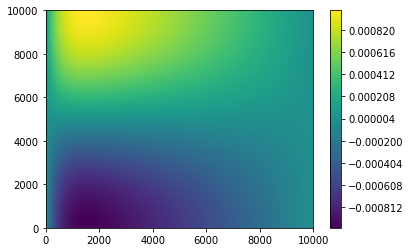

In [3]:
fieldset.U.show()

## ParticleSet creation

We do not create directly a single particle. In Parcels, we manipulate particles through a `ParticleSet`

a `ParticleSet` constructor needs to know the particle initial position (lon, lat, depth) and time. It also needs the Particle type `pclass` (e.g.: ScipyParticle, JITParticle) 

* Create a particle set with three particles located at longitude 100, 120, 130 and lat 5000.
* Advect the particles for one day, using a time step of 1 hour.
* Print the final positions of the particles

In [4]:
from parcels import ParticleSet, JITParticle, ScipyParticle, AdvectionEE
from datetime import timedelta as delta

lon = [100, 120, 130]
lat = [5000] * 3

pset = ParticleSet.from_list(fieldset, pclass=ScipyParticle,
                             lon=lon, lat=lat)

runtime = delta(days=1)
dt = delta(hours=1)
pset.execute(AdvectionEE, runtime=runtime, dt=dt)
for p in pset:
    print("lon: %g, lat: %g, time: %g" % (p.lon, p.lat, p.time) )


lon: 101.461, lat: 5523.76, time: 86400
lon: 121.64, lat: 5502.43, time: 86400
lon: 131.721, lat: 5491.78, time: 86400


While a ScipyParticle particle set is executed completely in Python, a JITParticle pset is executed in C.
* Evaluate the execution time for Scipy and JIT modes

INFO: Compiled JITParticleAdvectionEE ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/7b242b48e63c040d375ac2958b2c94f4.so


Scipy mode execution time: 2.86587 s
JIT mode execution time: 5.74199 s


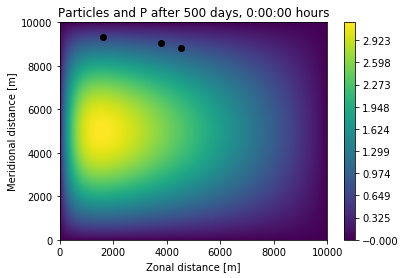

In [5]:
import time as timelib

runtime = delta(days=500)
dt = delta(hours=1)

psetScipy = ParticleSet.from_list(fieldset, pclass=ScipyParticle,
                                  lon=lon, lat=lat)
psetJIT = ParticleSet.from_list(fieldset, pclass=JITParticle,
                                lon=lon, lat=lat)

ticScipy = timelib.time()
psetScipy.execute(AdvectionEE, runtime=runtime, dt=dt)
tacScipy = timelib.time()
ticJIT = timelib.time()
psetJIT.execute(AdvectionEE, runtime=runtime, dt=dt)
tacJIT = timelib.time()

print("Scipy mode execution time: %g s" % (tacScipy-ticScipy))
print("JIT mode execution time: %g s" % (tacJIT-ticJIT))

psetJIT.show(field='P')

## Define a customised Particle

A important feature of Parcels is to enable a large variety of particles, which can contain user-defined variables.
The default variables are lon, lat, depth, time, id, but any other variable can be added by the user.

* Create a customed ParticleClass, containing two variables p and p_start.

In [6]:
from parcels import Variable

class MyParticle(JITParticle):
    p = Variable('p', dtype=np.float32, initial=0.)
    p_start = Variable('p_start', dtype=np.float32, initial=fieldset.P)


pset = ParticleSet.from_line(fieldset, size=4, pclass=MyParticle,
                             start=(100, 5000), finish=(200, 5000), time=0)
pset.execute(AdvectionEE, runtime=runtime, dt=dt)

for p in pset:
    print("lon: %g, lat: %g, time: %g, p: %g, p_start: %g" % (p.lon, p.lat, p.time, p.p, p.p_start) )


INFO: Compiled MyParticleAdvectionEE ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/cda54906743cff1a3aaff31e2a0ad3f1.so


lon: 1635.23, lat: 9346.16, time: 4.32e+07, p: 0, p_start: 0.678165
lon: 4735.69, lat: 8771.72, time: 4.32e+07, p: 0, p_start: 0.870433
lon: 6169.65, lat: 7919.9, time: 4.32e+07, p: 0, p_start: 1.05293
lon: 6774.35, lat: 6884.9, time: 4.32e+07, p: 0, p_start: 1.2251


There is no point to create new variables if they are not updated during the simulation

In [7]:
def UpdateP(particle, fieldset, time, dt):
    particle.p = fieldset.P[time, particle.lon, particle.lat, particle.depth]

pset = ParticleSet.from_line(fieldset, size=4, pclass=MyParticle,
                             start=(100, 5000), finish=(200, 5000), time=0)

runtime = delta(days=5)
dt = delta(minutes=1)
pset.execute(AdvectionEE+pset.Kernel(UpdateP), runtime=runtime, dt=dt)

for p in pset:
    print("lon: %g, lat: %g, time: %g, p: %g, p_start: %g" % (p.lon, p.lat, p.time, p.p, p.p_start) )

INFO: Compiled MyParticleAdvectionEEUpdateP ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/9ed96609196c85f78cf6b8ac70ef484f.so


lon: 139.484, lat: 7323.63, time: 432000, p: 0.675023, p_start: 0.678165
lon: 180.287, lat: 7179.28, time: 432000, p: 0.870146, p_start: 0.870433
lon: 219.037, lat: 7042.5, time: 432000, p: 1.05247, p_start: 1.05293
lon: 256.13, lat: 6912.14, time: 432000, p: 1.22349, p_start: 1.2251


## Particle file

To save the particle trajectories, a `ParticleFile` object can be created and called in the execution command.

In [8]:
pset = ParticleSet.from_line(fieldset, size=4, pclass=MyParticle,
                             start=(100, 5000), finish=(200, 5000), time=0)    
    
runtime = delta(days=300)
dt = delta(hours=1)
outputdt = delta(days=3)
output_file = pset.ParticleFile(name="StommelParticle", outputdt=outputdt)
pset.execute(AdvectionEE + pset.Kernel(UpdateP), runtime=runtime, dt=dt,
             output_file=output_file)



from parcels import plotTrajectoriesFile
plotTrajectoriesFile('StommelParticle.nc', mode='movie2d_notebook')

INFO: Compiled MyParticleAdvectionEEUpdateP ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/0de47eb378cac6bd532e6245d0a31815.so


## Runge-Kutta 4 time integration

* Instead of using the `AdvectionEE` kernel, define your own kernel, which integrates the velocity field using the Runge-Kutta 4 scheme.

In [10]:
pset = ParticleSet.from_line(fieldset, size=4, pclass=MyParticle,
                             start=(100, 5000), finish=(200, 5000), time=0)

def AdvectionRK4(particle, fieldset, time, dt):
    """Advection of particles using fourth-order Runge-Kutta integration.
    Function needs to be converted to Kernel object before execution"""
    (u1, v1) = fieldset.UV[time, particle.lon, particle.lat, particle.depth]
    lon1, lat1 = (particle.lon + u1*.5*dt, particle.lat + v1*.5*dt)
    (u2, v2) = fieldset.UV[time + .5 * dt, lon1, lat1, particle.depth]
    lon2, lat2 = (particle.lon + u2*.5*dt, particle.lat + v2*.5*dt)
    (u3, v3) = fieldset.UV[time + .5 * dt, lon2, lat2, particle.depth]
    lon3, lat3 = (particle.lon + u3*dt, particle.lat + v3*dt)
    (u4, v4) = fieldset.UV[time + dt, lon3, lat3, particle.depth]
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * dt




runtime = delta(days=50)
dt = delta(minutes=1)
pset.execute(pset.Kernel(AdvectionRK4)+pset.Kernel(UpdateP), runtime=runtime, dt=dt)

for p in pset:
    print("lon: %g, lat: %g, time: %g, p: %g, p_start: %g" % (p.lon, p.lat, p.time, p.p, p.p_start) )

INFO: Compiled MyParticleAdvectionRK4UpdateP ==> /var/folders/h0/01fvrmn11qb62yjw7v1kn62r0000gq/T/parcels-503/b7e15ee077751e016624aa75ddc34480.so


lon: 3282.63, lat: 9215.01, time: 4.32e+06, p: 0.673922, p_start: 0.678165
lon: 3328.15, lat: 8975.11, time: 4.32e+06, p: 0.86869, p_start: 0.870433
lon: 3341.26, lat: 8746.79, time: 4.32e+06, p: 1.05138, p_start: 1.05293
lon: 3332.64, lat: 8532.61, time: 4.32e+06, p: 1.22047, p_start: 1.2251
